# The Dataset
The data was downloaded from https://www.ibm.com/communities/analytics/watson-analytics-blog/guide-to-sample-datasets/ . This dataset was created to predict behavior to retain customers. We analyze all relevant customer data to help develop focused customer retention programs.


# Preprocessing

The following are the packages which will be used.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import scipy as sp
from sklearn import mixture
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import confusion_matrix

%matplotlib inline

Let's import the dataset and view the first 5 rows 

In [2]:
df=pd.read_csv('customer_churn.csv')
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


The dataset has 21 columns and most of the data is in textual form. For further processing, the data is converted to some numerical form based on its category.

In [3]:
mymap = {'Yes':1,'No':0,'No phone service':3,'No internet service':3,'Month-to-month':1,'One year':2,'Two year':3,'Electronic check':1,
        'Mailed check':2,'Bank transfer (automatic)':3,'Credit card (automatic)':4,'DSL':1,'Fiber optic':2,'Male':1,'Female':2}


df =df.applymap(lambda s: mymap.get(s) if s in mymap else s)

df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,2,0,1,0,1,0,3,1,0,...,0,0,0,0,1,1,1,29.85,29.85,0
1,5575-GNVDE,1,0,0,0,34,1,0,1,1,...,1,0,0,0,2,0,2,56.95,1889.5,0
2,3668-QPYBK,1,0,0,0,2,1,0,1,1,...,0,0,0,0,1,1,2,53.85,108.15,1
3,7795-CFOCW,1,0,0,0,45,0,3,1,1,...,1,1,0,0,2,0,3,42.30,1840.75,0
4,9237-HQITU,2,0,0,0,2,1,0,2,0,...,0,0,0,0,1,1,1,70.70,151.65,1


Let's view the data-type of each column.

In [4]:
df.dtypes

customerID           object
gender                int64
SeniorCitizen         int64
Partner               int64
Dependents            int64
tenure                int64
PhoneService          int64
MultipleLines         int64
InternetService       int64
OnlineSecurity        int64
OnlineBackup          int64
DeviceProtection      int64
TechSupport           int64
StreamingTV           int64
StreamingMovies       int64
Contract              int64
PaperlessBilling      int64
PaymentMethod         int64
MonthlyCharges      float64
TotalCharges         object
Churn                 int64
dtype: object

TotalCharges are read as string. Change this to numeric form.

In [5]:
df['TotalCharges']= df['TotalCharges'].convert_objects(convert_numeric=True)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


Let’s get an understanding of the data before we go any further. Lets use df.describe() to look at all the variables.

In [6]:
df.describe()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7032.000000,7043.000000
mean,1.495244,0.162147,0.483033,0.299588,32.371149,0.903166,0.712338,1.222916,0.936675,0.994889,0.993895,0.940224,1.034360,1.037910,1.690473,0.592219,2.315633,64.761692,2283.300441,0.265370
std,0.500013,0.368612,0.499748,0.458110,24.559481,0.295752,0.886581,0.778877,1.165986,1.142491,1.142921,1.164650,1.124568,1.122874,0.833755,0.491457,1.148907,30.090047,2266.771362,0.441561
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,18.250000,18.800000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,35.500000,401.450000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,29.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,70.350000,1397.475000,0.000000
75%,2.000000,0.000000,1.000000,1.000000,55.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,89.850000,3794.737500,1.000000
max,2.000000,1.000000,1.000000,1.000000,72.000000,1.000000,3.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,1.000000,4.000000,118.750000,8684.800000,1.000000


We can observe TotalCharges has 7032 count wheras all other have 7043. It means that TotalCharges has a few values missing. The missing values will be replaced by 0 for now.

In [7]:
df['TotalCharges']= df['TotalCharges'].fillna(0)

# Visualizing

Now we will visualize the dataset. This is done in order to get more details and corelations from the data.



Let's plot the histogram of the dataset. This is done to get to know more about the distribution of the data.

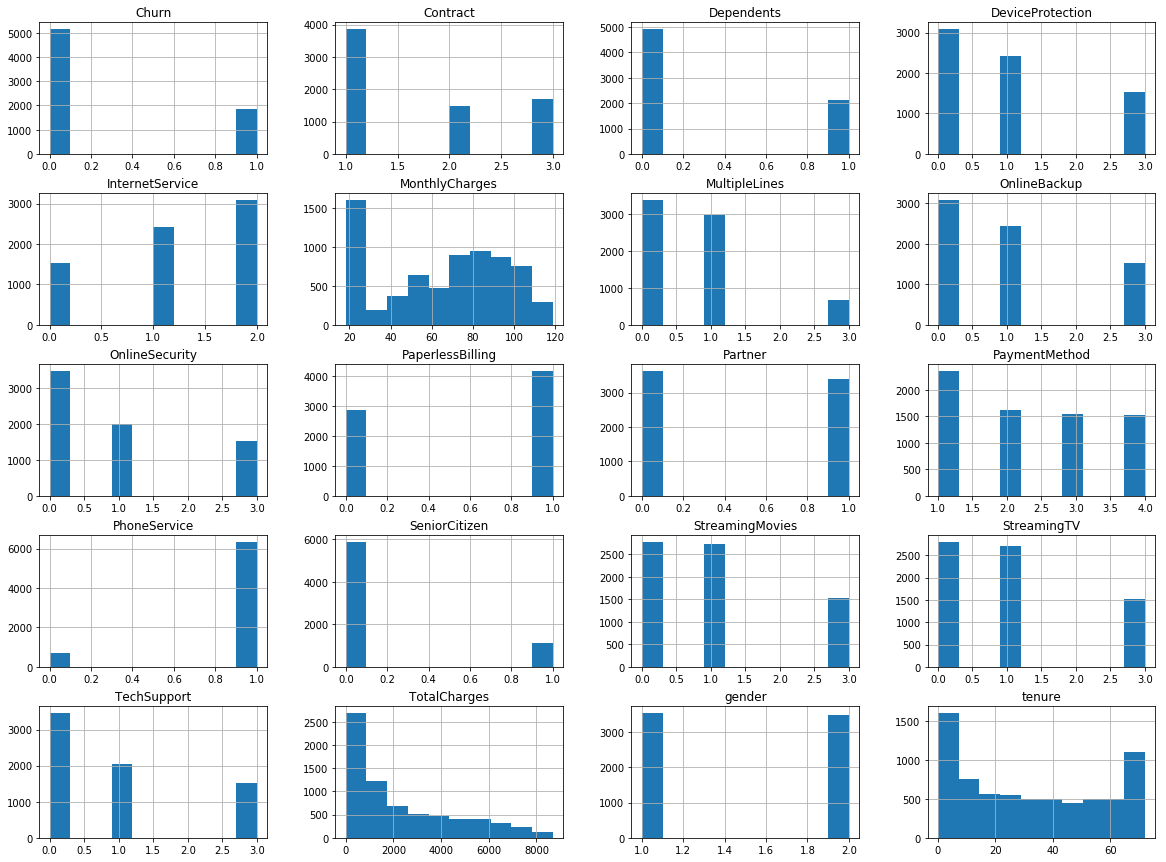

In [8]:
num_bins = 10

df.hist(bins=num_bins, figsize=(20,15))
plt.savefig("df_histogram_plots")
plt.show()

All of the categorical variables seem to have a reasonably broad distribution, therefore, all of them will be kept for the further analysis.

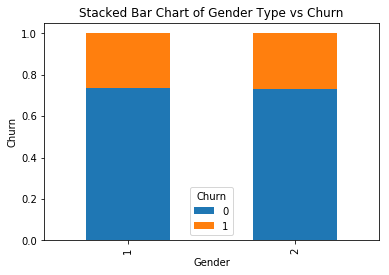

In [9]:
table=pd.crosstab(df.gender, df.Churn)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Gender Type vs Churn')
plt.xlabel('Gender')
plt.ylabel('Churn')
plt.savefig('churn_bar_chart')

By looking at the above plot, we can see that there does not seem to be a relationship between gender and churn.

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


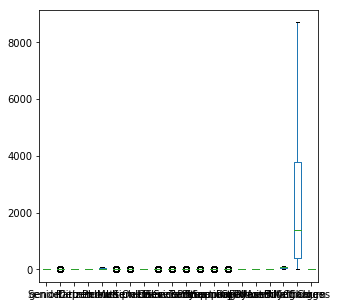

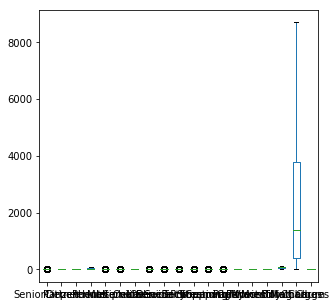

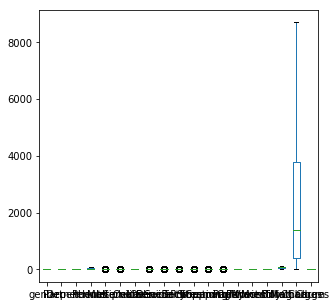

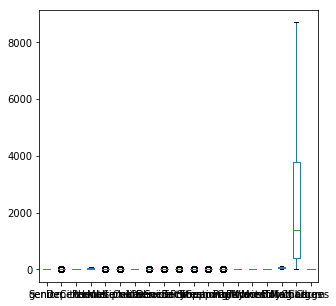

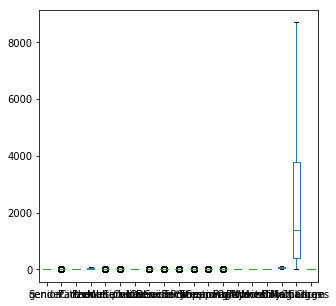

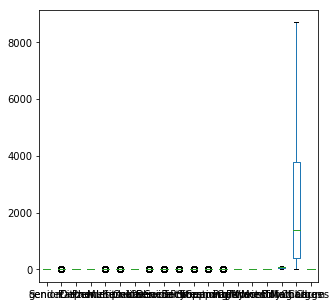

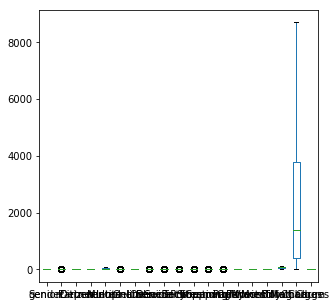

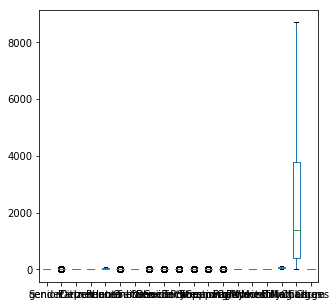

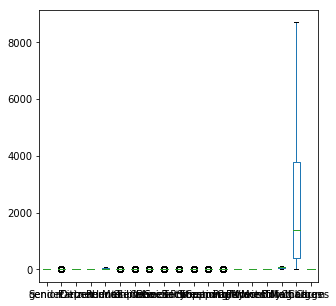

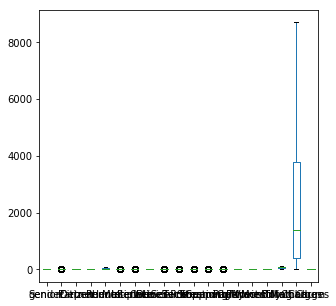

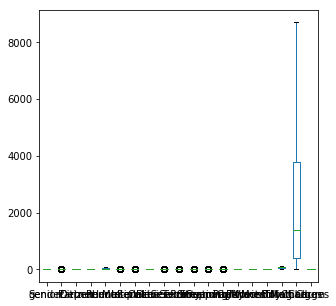

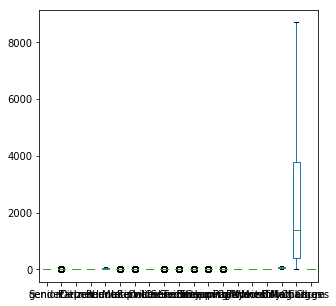

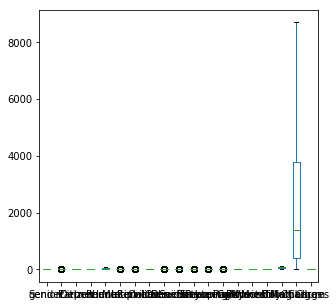

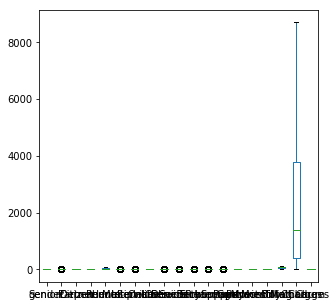

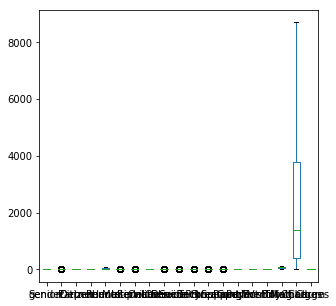

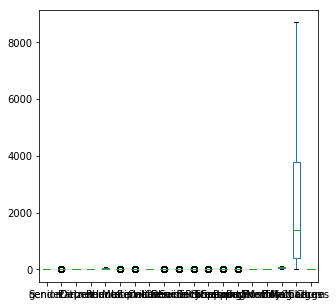

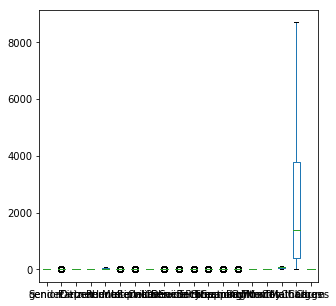

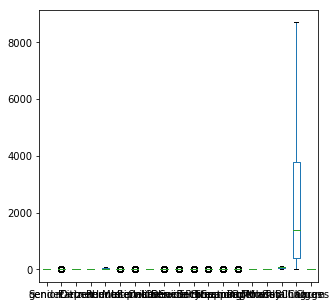

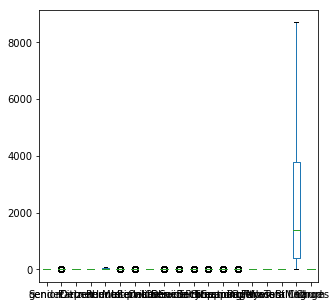

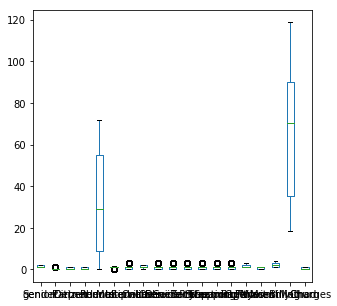

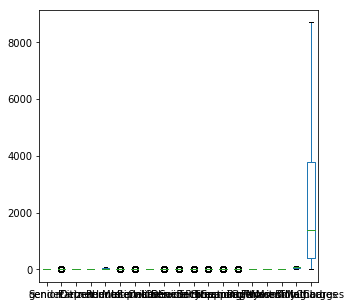

In [10]:
#Box Plots
for col in df.columns:
    df.plot([col],kind='box',figsize=[5,5])

Scatter Matrix can be used to find if there are any correlations between the variables

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f315f1a2d68>,
      dtype=object)

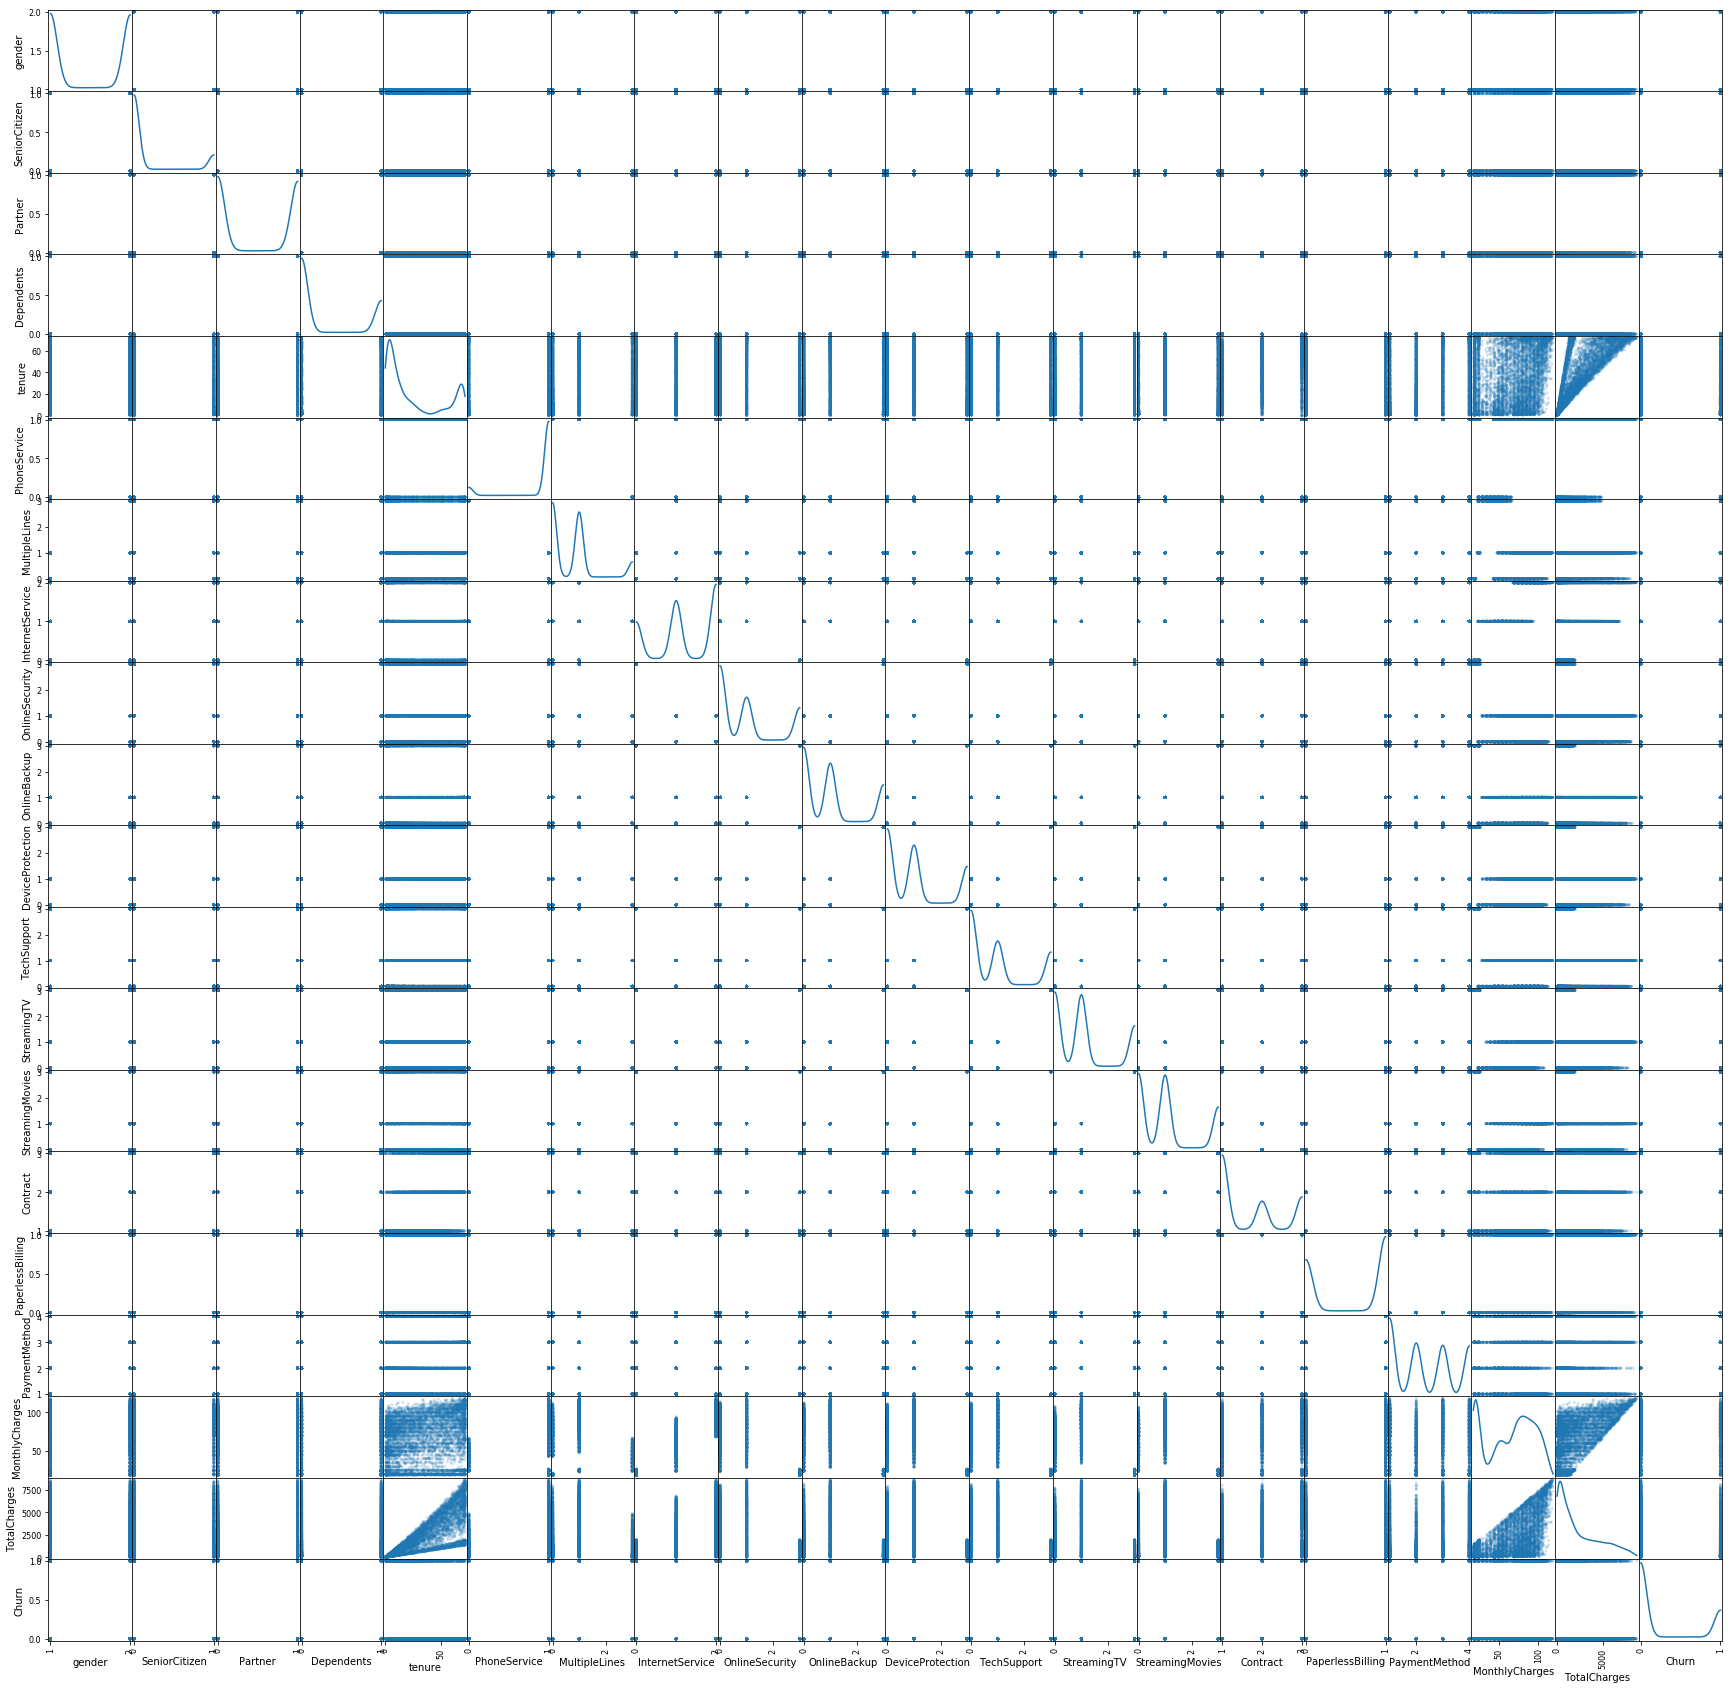

In [11]:
from pandas.plotting import scatter_matrix
scatter_matrix(df,alpha=0.2, figsize=(30,30), diagonal='kde')


We notice that the Monthly Charges and Total Charges are correlated. So one of them will be removed from the model. We remove Total Charges.

In [12]:
df=df.drop(columns=['TotalCharges'])
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,7590-VHVEG,2,0,1,0,1,0,3,1,0,1,0,0,0,0,1,1,1,29.85,0
1,5575-GNVDE,1,0,0,0,34,1,0,1,1,0,1,0,0,0,2,0,2,56.95,0
2,3668-QPYBK,1,0,0,0,2,1,0,1,1,1,0,0,0,0,1,1,2,53.85,1
3,7795-CFOCW,1,0,0,0,45,0,3,1,1,0,1,1,0,0,2,0,3,42.30,0
4,9237-HQITU,2,0,0,0,2,1,0,2,0,0,0,0,0,0,1,1,1,70.70,1


# Prediction

Let's create some predictive models on our dataset. First we partition the dataset and form the training and testing sets.

In [13]:
dataset=df.iloc[:,1:19] #we dont need to consider customerID
#print(dataset.head())
train_size = int(len(dataset) * 0.8)  #80% training and 20% testing
test_size = len(dataset) - train_size
X_train , X_test = dataset[0:train_size], dataset[train_size:len(dataset)]
output = df.iloc[:,19]
y_train , y_test=output[0:train_size],output[train_size:len(dataset)]
#y_train.head()

### Logistic Regression
In statistics, the logistic model (or logit model) is a statistical model that is usually taken to apply to a binary dependent variable. In regression analysis, logistic regression or logit regression is estimating the parameters of a logistic model. Below is the code to perform the same.

In [14]:
from sklearn.linear_model import LogisticRegression
# Create logistic regression object
model = LogisticRegression()

# Train the model using the training sets and check score
model.fit(X_train, y_train)
#model.score(X_test, y_test)

#Equation coefficient and Intercept
print('Coefficient: \n', model.coef_)
print('Intercept: \n', model.intercept_)

#Predict Output
predicted= model.predict(X_test)

#Print accuracy
accuracy = metrics.accuracy_score(predicted,y_test)
print ("Accuracy : %s" % "{0:.3%}".format(accuracy))

Coefficient: 
 [[ 0.03066208  0.17102347  0.04490163 -0.20788149 -0.03357197  0.52877655
   0.28836132  1.15163127 -0.33365207 -0.06770609  0.056487   -0.40132385
   0.38943968  0.36403888 -0.65868519  0.39061917 -0.1541636  -0.00954624]]
Intercept: 
 [-0.92589177]
Accuracy : 80.412%


### Decision Tree
Decision tree is a type of supervised learning algorithm (having a pre-defined target variable) that is mostly used in classification problems. It works for both categorical and continuous input and output variables. In this technique, we split the population or sample into two or more homogeneous sets (or sub-populations) based on most significant splitter / differentiator in input variables.

In [15]:
from sklearn import tree
# Create tree object 
model = tree.DecisionTreeClassifier(criterion='gini') # for classification, here you can change the algorithm as gini or entropy (information gain) by default it is gini  
# model = tree.DecisionTreeRegressor() for regression

# Train the model using the training sets and check score
model.fit(X_train, y_train)

#Predict Output
predicted= model.predict(X_test)

#Print accuracy
accuracy = metrics.accuracy_score(predicted,y_test)
print ("Accuracy : %s" % "{0:.3%}".format(accuracy))

Accuracy : 73.882%


### Random Forest
 Random forest builds multiple decision trees and merges them together to get a more accurate and stable prediction.

In [16]:
from sklearn.ensemble import RandomForestClassifier

# Create Random Forest object
model= RandomForestClassifier()

model.fit(X_train, y_train)

predicted= model.predict(X_test)

accuracy = metrics.accuracy_score(predicted,y_test)
print ("Accuracy : %s" % "{0:.3%}".format(accuracy))

Accuracy : 78.992%


### SVM (Support Vector Machine)
“Support Vector Machine” (SVM) is a supervised machine learning algorithm which can be used for both classification or regression challenges. However,  it is mostly used in classification problems. In this algorithm, each data item is plotted as a point in n-dimensional space (where n is number of features you have) with the value of each feature being the value of a particular coordinate. Then, classification is performed by finding the hyper-plane that differentiate the two classes very well (look at the below snapshot).

In [17]:
from sklearn import svm
#Assumed you have, X (predictor) and Y (target) for training data set and x_test(predictor) of test_dataset
# Create SVM classification object 
model = svm.SVC() 

model.fit(X_train, y_train)

predicted= model.predict(X_test)

accuracy = metrics.accuracy_score(predicted,y_test)
print ("Accuracy : %s" % "{0:.3%}".format(accuracy))

Accuracy : 78.708%


### A simple neural network model
An artificial neural network is a biologically inspired computational model formed from many single units, artificial neurons, connected with coefficients (weights) which constitute the neural structure. We'll use keras to create the neural model. 

In [18]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras import optimizers
import csv

model = Sequential()
model.add(Dense(18,input_dim=18, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

opt = optimizers.SGD(lr=0.01)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=200, batch_size=300,validation_data=(X_test, y_test))
scores = model.evaluate(X_test, y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Train on 5634 samples, validate on 1409 samples
Epoch 1/200
5634/5634 [==============================] - 0s 57us/step - loss: 2.7412 - acc: 0.6942 - val_loss: 1.8974 - val_acc: 0.7296
Epoch 2/200
5634/5634 [==============================] - 0s 10us/step - loss: 1.6502 - acc: 0.6803 - val_loss: 0.4872 - val_acc: 0.7495
Epoch 3/200
5634/5634 [==============================] - 0s 9us/step - loss: 0.9596 - acc: 0.7089 - val_loss: 0.4742 - val_acc: 0.7821
Epoch 4/200
5634/5634 [==============================] - 0s 9us/step - loss: 0.8012 - acc: 0.7194 - val_loss: 0.4804 - val_acc: 0.7807
Epoch 5/200
5634/5634 [==============================] - 0s 10us/step - loss: 0.7208 - acc: 0.7279 - val_loss: 0.4799 - val_acc: 0.7750
Epoch 6/200
5634/5634 [==============================] - 0s 10us/step - loss: 0.6805 - acc: 0.7196 - val_loss: 0.4689 - val_acc: 0.7864
Epoch 7/200
5634/5634 [==============================] - 0s 9us/step - loss: 0.6246 - acc: 0.7354 - val_loss: 0.4707 - val_acc: 0.7885
Epo

Epoch 61/200
5634/5634 [==============================] - 0s 10us/step - loss: 0.4414 - acc: 0.7838 - val_loss: 0.4329 - val_acc: 0.7885
Epoch 62/200
5634/5634 [==============================] - 0s 9us/step - loss: 0.4464 - acc: 0.7819 - val_loss: 0.4350 - val_acc: 0.7892
Epoch 63/200
5634/5634 [==============================] - 0s 9us/step - loss: 0.4442 - acc: 0.7843 - val_loss: 0.4348 - val_acc: 0.7928
Epoch 64/200
5634/5634 [==============================] - 0s 10us/step - loss: 0.4428 - acc: 0.7783 - val_loss: 0.4340 - val_acc: 0.7878
Epoch 65/200
5634/5634 [==============================] - 0s 9us/step - loss: 0.4432 - acc: 0.7870 - val_loss: 0.4348 - val_acc: 0.7913
Epoch 66/200
5634/5634 [==============================] - 0s 9us/step - loss: 0.4439 - acc: 0.7884 - val_loss: 0.4381 - val_acc: 0.7913
Epoch 67/200
5634/5634 [==============================] - 0s 9us/step - loss: 0.4427 - acc: 0.7874 - val_loss: 0.4335 - val_acc: 0.7928
Epoch 68/200
5634/5634 [======================

Epoch 121/200
5634/5634 [==============================] - 0s 14us/step - loss: 0.4302 - acc: 0.7874 - val_loss: 0.4349 - val_acc: 0.7921
Epoch 122/200
5634/5634 [==============================] - 0s 12us/step - loss: 0.4289 - acc: 0.7945 - val_loss: 0.4287 - val_acc: 0.8006
Epoch 123/200
5634/5634 [==============================] - 0s 13us/step - loss: 0.4328 - acc: 0.7890 - val_loss: 0.4271 - val_acc: 0.8006
Epoch 124/200
5634/5634 [==============================] - 0s 13us/step - loss: 0.4350 - acc: 0.7865 - val_loss: 0.4320 - val_acc: 0.7949
Epoch 125/200
5634/5634 [==============================] - 0s 14us/step - loss: 0.4314 - acc: 0.7906 - val_loss: 0.4297 - val_acc: 0.7970
Epoch 126/200
5634/5634 [==============================] - 0s 12us/step - loss: 0.4349 - acc: 0.7863 - val_loss: 0.4288 - val_acc: 0.7970
Epoch 127/200
5634/5634 [==============================] - 0s 13us/step - loss: 0.4345 - acc: 0.7877 - val_loss: 0.4286 - val_acc: 0.7963
Epoch 128/200
5634/5634 [=========

5634/5634 [==============================] - 0s 12us/step - loss: 0.4227 - acc: 0.7993 - val_loss: 0.4282 - val_acc: 0.7977
Epoch 181/200
5634/5634 [==============================] - 0s 14us/step - loss: 0.4261 - acc: 0.7955 - val_loss: 0.4290 - val_acc: 0.7984
Epoch 182/200
5634/5634 [==============================] - 0s 13us/step - loss: 0.4252 - acc: 0.7938 - val_loss: 0.4259 - val_acc: 0.7963
Epoch 183/200
5634/5634 [==============================] - 0s 14us/step - loss: 0.4271 - acc: 0.7984 - val_loss: 0.4259 - val_acc: 0.7991
Epoch 184/200
5634/5634 [==============================] - 0s 13us/step - loss: 0.4246 - acc: 0.7975 - val_loss: 0.4261 - val_acc: 0.8034
Epoch 185/200
5634/5634 [==============================] - 0s 12us/step - loss: 0.4239 - acc: 0.8037 - val_loss: 0.4283 - val_acc: 0.7991
Epoch 186/200
5634/5634 [==============================] - 0s 11us/step - loss: 0.4239 - acc: 0.7996 - val_loss: 0.4255 - val_acc: 0.8020
Epoch 187/200
5634/5634 [=======================